In [1]:
import pandas as pd
import numpy as np
import os
import math
import re
from collections import Counter
import random

import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 导入FontProperties
import warnings
warnings.filterwarnings("ignore")

In [2]:
path1 = r'E:\netData\APS\1 Authors\APS_authors 2.0.zip'

In [3]:
fau = pd.read_csv(path1)
fau['type'] = fau['type'].map(dict(zip(['获奖学者','非获奖学者'] , ['laureate' , 'non laureate'])))
fau['treatment'] = fau['type'].map(dict(zip(['laureate' , 'non laureate'] , [1 , 0])))

In [4]:
data = fau[['pub_num','h','g', 'tc','DC','CC', 'dh', 'ch','type']].copy()

In [5]:
data['mc'] = data['tc']/data['pub_num']

In [6]:
d1 = data[data['type'] == 'laureate'].copy()
d2 = data[data['type'] == 'non laureate'].copy()
d1.index = range(len(d1))
d2.index = range(len(d2))

In [7]:
def get_control_group(d1, d2, da):
    lst = []
    for n in d1[da].values:
        diff = np.abs(d2[da] - n)
        idx = diff.idxmin()
        lst.append(idx)
    d3 = d2.iloc[lst, :].copy()
    return d3

In [9]:
d31 = get_control_group(d1,d2,'tc')
d31['type'] = 'control c'
dd1 = pd.concat([d1,d31])

d32 = get_control_group(d1,d2,'h')
d32['type'] = 'control h'
dd2 = pd.concat([d1,d32])

d33 = get_control_group(d1,d2,'g')
d33['type'] = 'control g'
dd3 = pd.concat([d1,d33])

In [27]:
labels = ['SDC','D h-index','SCC','C h-index']
valst = ['DC','dh','CC','ch']

palettes = [['#21618C','#D35400'],['#21618C','#943126'],['#21618C','#138D75']]

controllst = ['tc','h','g']
ddlst = [dd1,dd2,dd3]

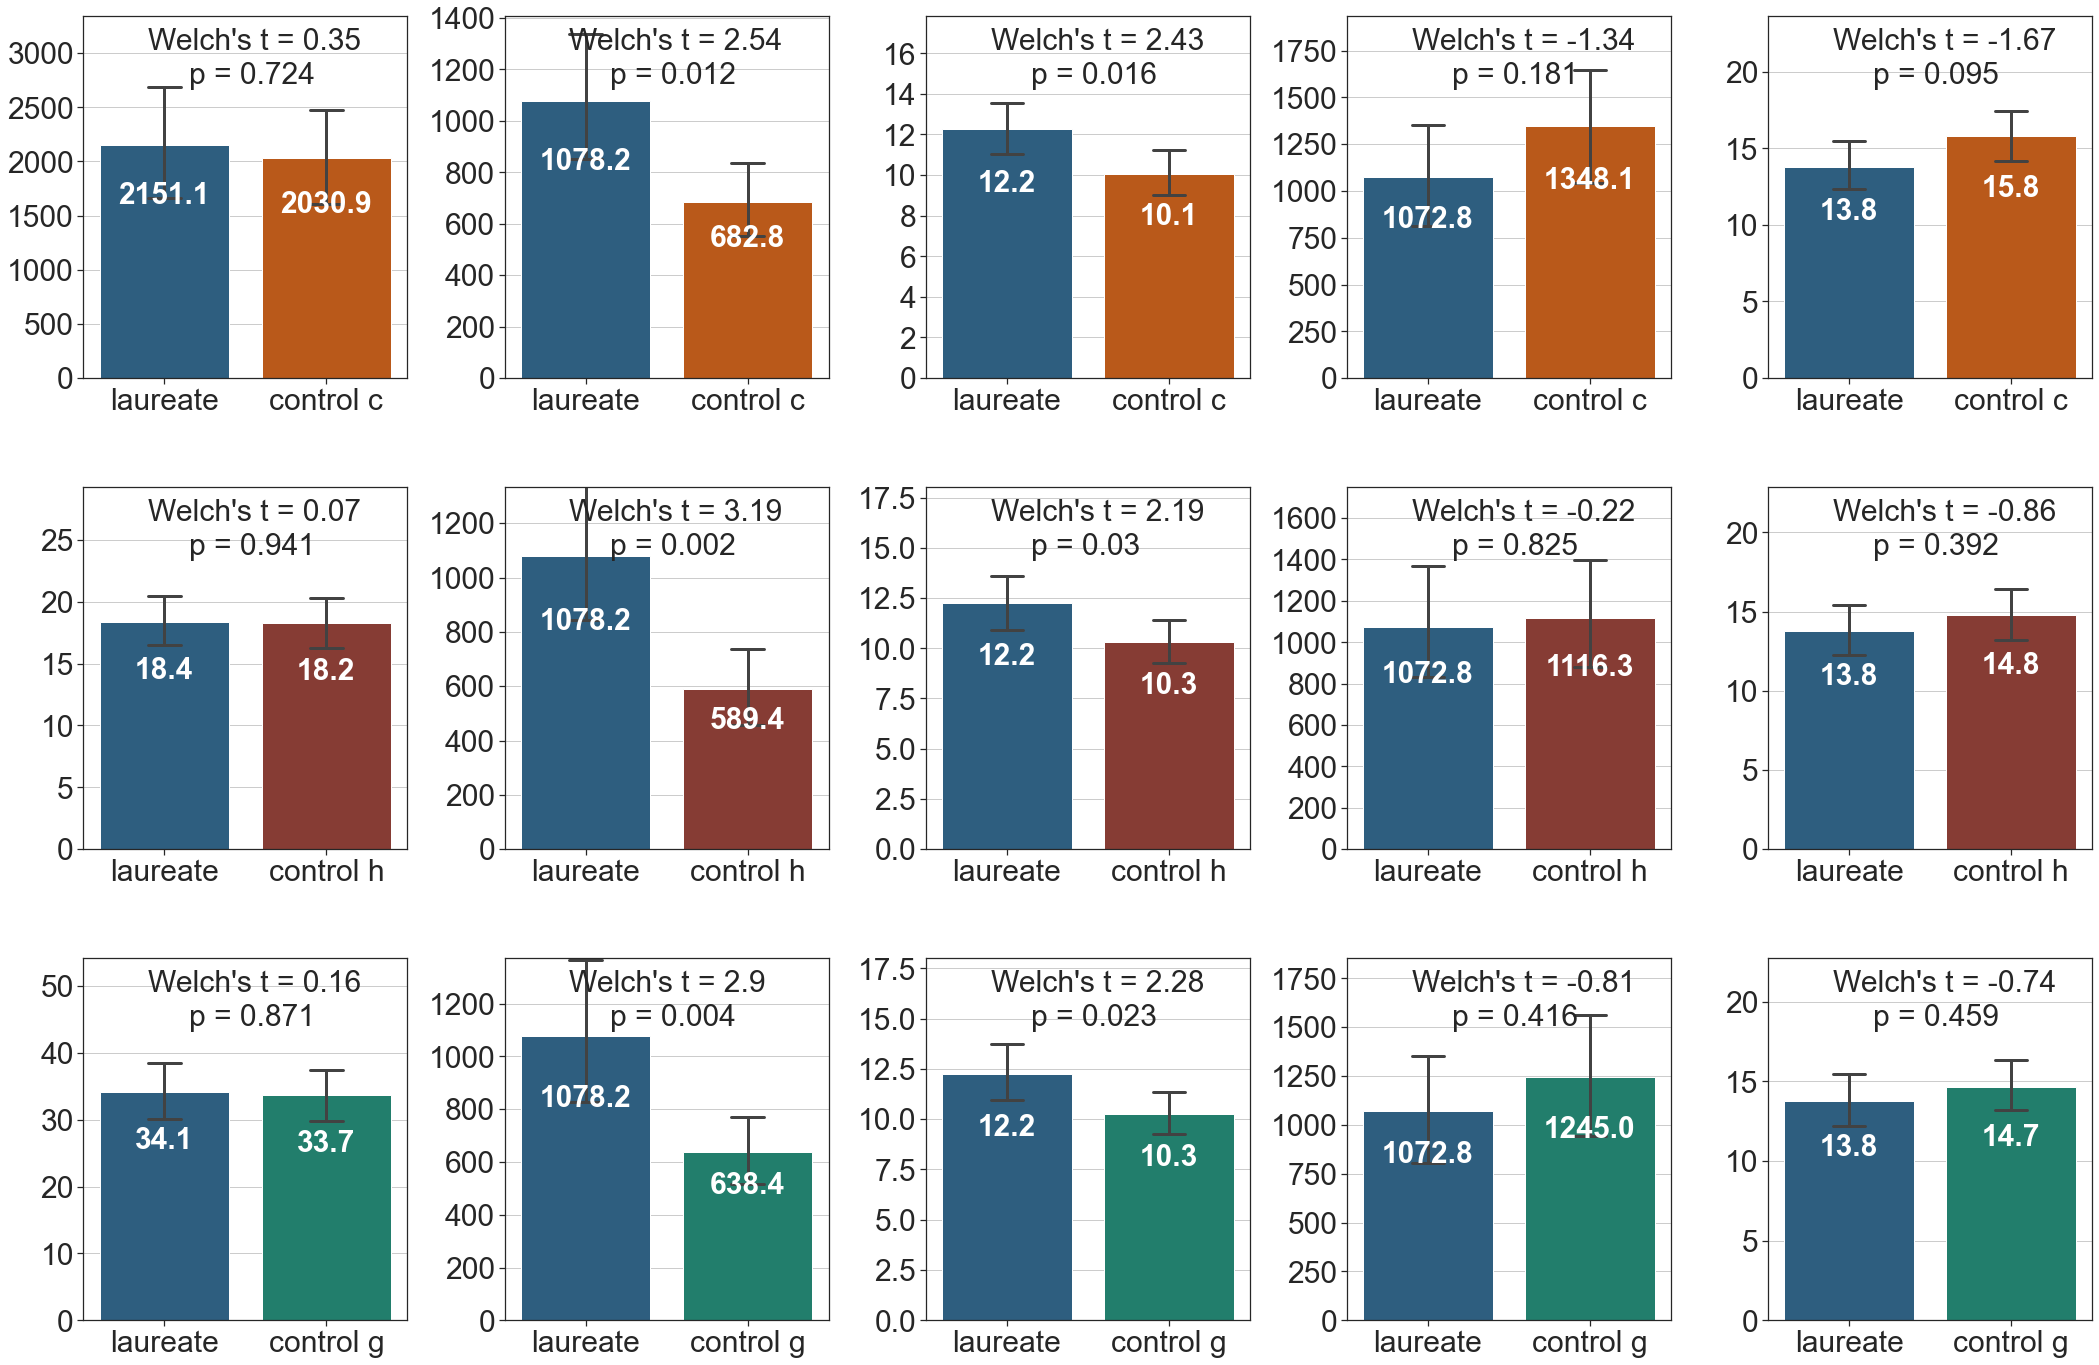

In [39]:
plt.subplots(3,5,figsize=(36,24))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
sns.set_theme(style="ticks")

for i in range(3):
    ax = plt.subplot(3, 5, i*5+1)
    data = ddlst[i]
    sns.barplot(data=data, x="type", y=controllst[i], errwidth=3, capsize=.2, palette=palettes[i])
    ax.yaxis.grid(True)
    t, p = scipy.stats.ttest_ind(data[data['type']=='laureate'][controllst[i]].dropna(),
                                  data[data['type']!='laureate'][controllst[i]].dropna(),
                                  equal_var=False, alternative='two-sided')

    plt.text(-0.1, np.mean(data[controllst[i]])*1.45, "Welch's t = {}".format(np.around(t, 2)), fontsize=30)
    plt.text(0.15, np.mean(data[controllst[i]])*1.3, "p = {}".format(np.around(p, 3)), fontsize=30)

    plt.text(0, np.mean(data[data['type']=='laureate'][controllst[i]])*0.75, 
             "{}".format(np.around(np.mean(data[data['type']=='laureate'][controllst[i]]), 1)),c = 'white', fontsize=30, ha='center', fontweight='bold')
    plt.text(1, np.mean(data[data['type']!='laureate'][controllst[i]])*0.75,
             "{}".format(np.around(np.mean(data[data['type']!='laureate'][controllst[i]]), 1)),c = 'white', fontsize=30, ha='center', fontweight='bold')

    plt.ylim((0, np.mean(data[controllst[i]])*1.6))
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('')
    plt.ylabel('')

    for j in range(4):
        ax = plt.subplot(3, 5, i*5+j+2)
        sns.barplot(data=data, x="type", y=valst[j], errwidth=3, capsize=.2, palette=palettes[i])
        ax.yaxis.grid(True)   
        t, p = scipy.stats.ttest_ind(data[data['type']=='laureate'][valst[j]].dropna(),
                                      data[data['type']!='laureate'][valst[j]].dropna(),
                                      equal_var=False, alternative='two-sided')
        plt.text(-0.1, np.mean(data[valst[j]])*1.45, "Welch's t = {}".format(np.around(t, 2)), fontsize=30)
        plt.text(0.15, np.mean(data[valst[j]])*1.3, "p = {}".format(np.around(p, 3)), fontsize=30)

        plt.text(0, np.mean(data[data['type']=='laureate'][valst[j]])*0.75,
                 "{}".format(np.around(np.mean(data[data['type']=='laureate'][valst[j]]), 1)),c = 'white', fontsize=30, ha='center', fontweight='bold')
        plt.text(1, np.mean(data[data['type']!='laureate'][valst[j]])*0.75,
                 "{}".format(np.around(np.mean(data[data['type']!='laureate'][valst[j]]), 1)),c = 'white', fontsize=30, ha='center', fontweight='bold')

        plt.ylim((0, np.mean(data[valst[j]])*1.6))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('')
        plt.ylabel('')

plt.savefig(r"G:\A J YANG PAPER\APS analysis\IPM SDC SCC\fig\fig 7\0.pdf",bbox_inches = 'tight')

In [40]:
def get_control_group2(d1, d2, da1, da2):
    lst = []
    for i in range(len(d1)):
        n1 = d1[da1].values[i]
        n2 = d1[da2].values[i]
        
        # find the value in d2[da1] that is closest to n1
        diff1 = np.abs(d2[da1] - n1)
        idx1 = diff1.idxmin()
        
        # find the value in d2[da2] that is closest to n2, using only rows where d2[da1] == d2.loc[idx1, da1]
        diff2 = np.abs(d2.loc[d2[da1] == d2.loc[idx1, da1], da2] - n2)
        idx2 = diff2.idxmin()
        
        lst.append(idx2)
    d3 = d2.iloc[lst, :].copy()
    return d3

In [41]:
d34 = get_control_group2(d1,d2,'tc','pub_num')
d34['type'] = 'control pc'
dd4 = pd.concat([d1,d34])

In [47]:
labels = ['SDC','D h-index','SCC','C h-index']
valst = ['DC','dh','CC','ch']

palettes = [['#21618C','#212F3D'],['#21618C','#7D3C98']]


controllst = ['tc','pub_num']
ddlst = [dd4,dd4]

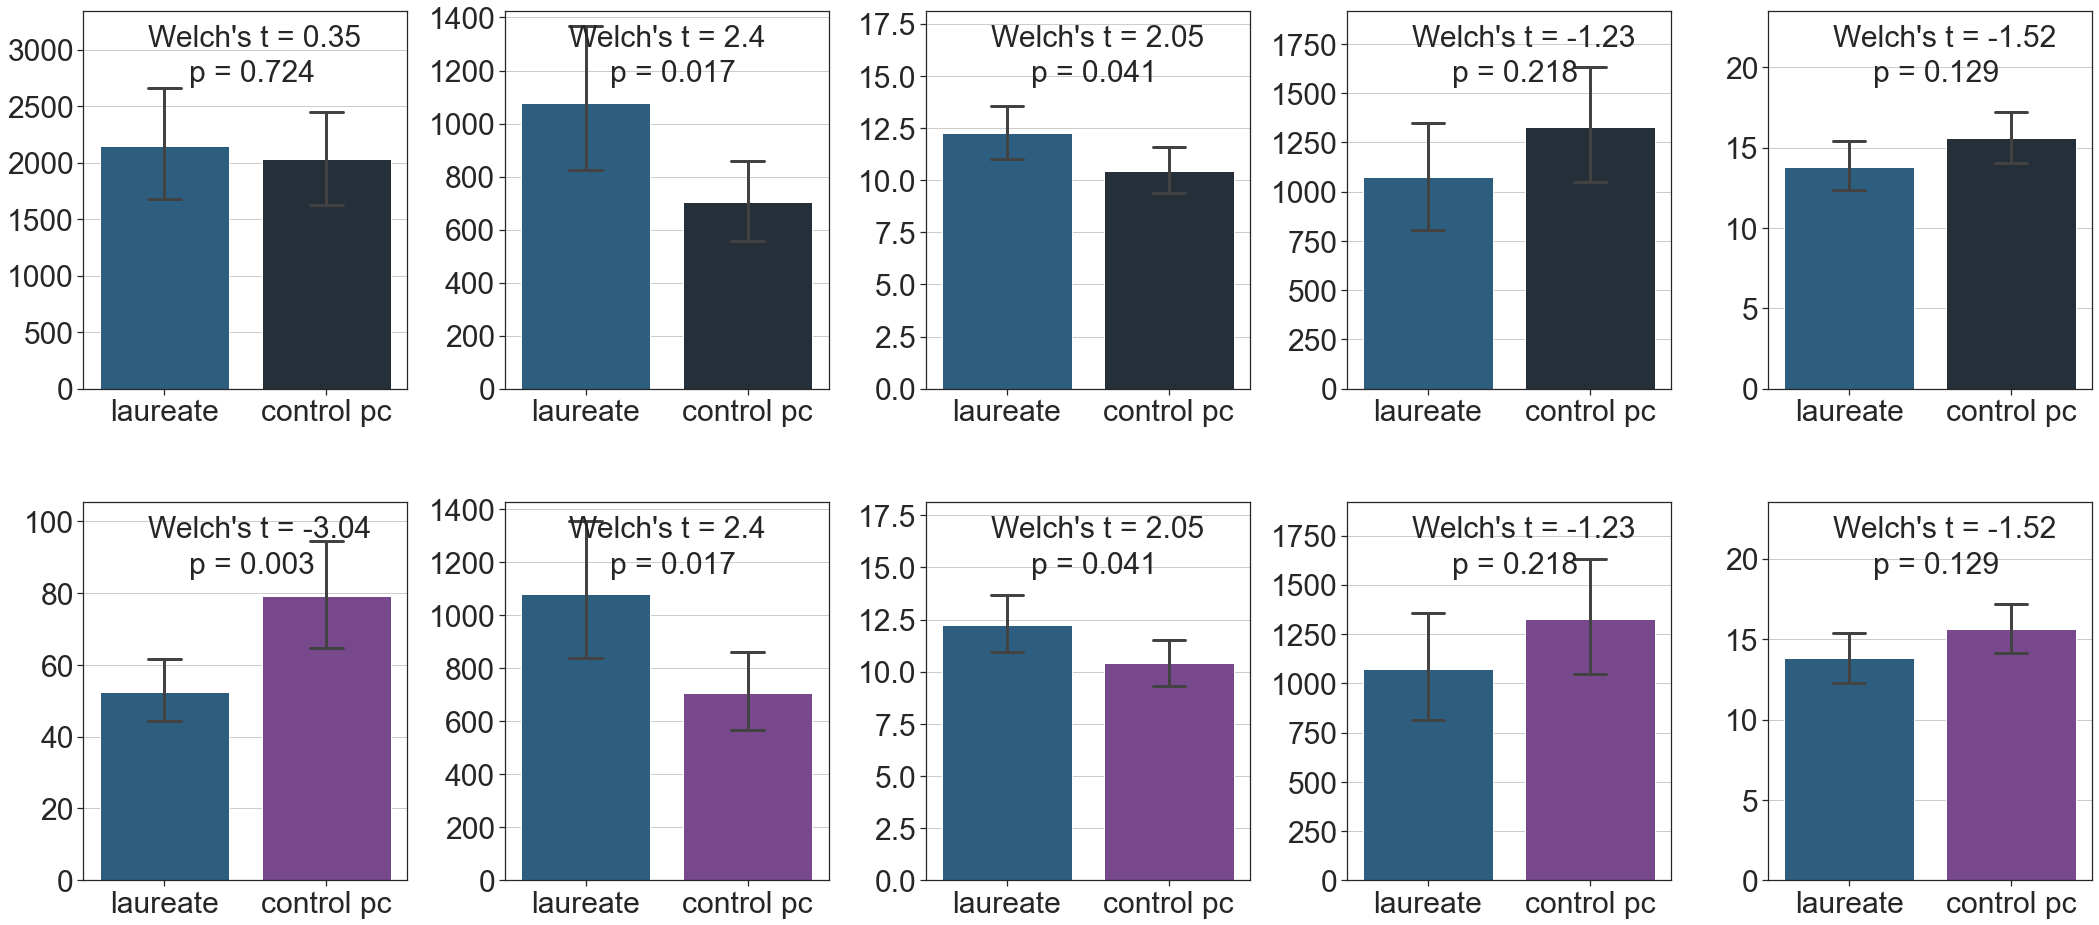

In [49]:
plt.subplots(2,5,figsize=(36,16))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
sns.set_theme(style="ticks")

for i in range(2):
    ax = plt.subplot(2,5,i*5+1)
    data = ddlst[i]
    sns.barplot(data=data, x="type", y=controllst[i] , errwidth=3, capsize=.2,palette=palettes[i])
    ax.yaxis.grid(True)
    t,p = scipy.stats.ttest_ind(data[data['type']=='laureate'][controllst[i]].dropna() , data[data['type']!='laureate'][controllst[i]].dropna(), equal_var=False, alternative='two-sided')
    plt.text(-0.1,np.mean(data[controllst[i]])*1.45,"Welch's t = {}".format(np.around (t, 2 )),fontsize = 30)
    plt.text(0.15,np.mean(data[controllst[i]])*1.3, "p = {}".format(np.around (p, 3 )),fontsize = 30)
    plt.ylim((0 , np.mean(data[controllst[i]])*1.6))
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.xlabel('')
    plt.ylabel('')
    for j in range(4):
        ax = plt.subplot(2,5,i*5+j+2)
        sns.barplot(data=data, x="type", y=valst[j] , errwidth=3, capsize=.2,palette=palettes[i])
        ax.yaxis.grid(True)   
        t,p = scipy.stats.ttest_ind(data[data['type']=='laureate'][valst[j]].dropna() , data[data['type']!='laureate'][valst[j]].dropna(), equal_var=False, alternative='two-sided')
        plt.text(-0.1,np.mean(data[valst[j]])*1.45,"Welch's t = {}".format(np.around (t, 2 )),fontsize = 30)
        plt.text(0.15,np.mean(data[valst[j]])*1.3, "p = {}".format(np.around (p, 3 )),fontsize = 30)
        plt.ylim((0 , np.mean(data[valst[j]])*1.6))
        plt.xticks(fontsize = 30)
        plt.yticks(fontsize = 30)
        plt.xlabel('')
        plt.ylabel('')

#plt.savefig(r"G:\A J YANG PAPER\APS analysis\IPM SDC SCC\fig\fig 7\1.pdf",bbox_inches = 'tight')